In [180]:
This is version 2 of the notebook using the dataset with actual response variables.

SyntaxError: invalid syntax (<ipython-input-180-6cf68688db96>, line 1)

# TODO

- read up on preprocessing for PCA
- rerun manova with all data
- Ask for the data on separate runs... 
- dendrogram: which groups are closest
- OPT if applicable: inverse PCA transformation - get transformation for future data points to be comparable (the 'index' idea) (sklearns transformer)
- OPT How does gait/GI change with age?
- PERCENTAGES - not normal
- inconsistent names?

FP_StrideLength_(cm)_Mean

LF_StrideLength_(cm)_Mean

RH_SingleStance_(s)_Mean

LH_SingleStance_(s)_Mean

RF_SingleStance_(s)_Mean

- transform values to absolute value?

# NOTES
- the proper pre-PCA transformation appears to be: 1) normalize to [-1,1]; 2) mean-center
- frame it this way: We want to get a transformation of those varibles that reflects the age difference. Hence we calculate differences between YC and AC. On this basis -> Gait Index, which is then used to distinguish between Youngness and Oldness. Train and Test data -> CV.

# DATA INFO
- In mouse number the first digit is the cage number

In [181]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from vacou import *
from plots import *
from pairwise import pairwise_distances_pd

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import *
from skbio.stats.distance import mantel

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
#sns.set(font="monospace")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
data_fp = '/P/vacou/data/SS31_gait_data_for_PCA.tsv'
sep_runs_data_fp = '/P/vacou/data/all_separate_runs.csv'
#d_orig = pd.read_csv(data_fp, sep='\t')
response_column = 'Group'

In [183]:
d2, md2, full_df2 = preprocess_vc(version = 2, 
    data_fp=data_fp, use_vars_fp='data/use_variables.csv'
    )
d3, md3, full_df3 = preprocess_vc(version = 3, 
    data_fp=sep_runs_data_fp, use_vars_fp='data/use_variables.csv'
    )
d4, md4, full_df4 = preprocess_vc(version = 4, 
    data_fp=data_fp, sep_runs_data_fp=sep_runs_data_fp,
    use_vars_fp='data/use_variables.csv'
    )

In [184]:
print(d2.shape, md2.shape, full_df2.shape)
print(d3.shape, md3.shape, full_df3.shape)
print(d4.shape, md4.shape, full_df4.shape)

(45, 64) (45, 2) (45, 192)
(111, 63) (111, 4) (111, 419)
(156, 63) (156, 2) (156, 179)


In [227]:
d.to_csv('data/data_ss31.tsv', sep='\t')
md.to_csv('data/md.tsv', sep='\t')
full_df.to_csv('data/data_ss31_with_md.tsv', sep="\t")

#### After some exploratory plots I chose this to be dataset:

In [185]:
d = d2
md = md2
full_df = full_df2
#dp = pd.DataFrame(scale(d), columns=d.columns, index=d.index)
dp = pd.DataFrame(scale(minmax_scale(d), with_std=True),
                  columns=d.columns, index=d.index)
#dp = pd.DataFrame(robust_scale(d, with_std=True), columns=d.columns, index=d.index)

# Exploratory

In [186]:
print('Take a look at some data columns')
full_df.columns.tolist()[:5]

Take a look at some data columns


['Group',
 'Animal',
 'Run_Duration_(s)_Mean',
 'Run_Average_Speed_(cm/s)_Mean',
 'Run_Maximum_Variation_(%)_Mean']

In [187]:
print('Summarise data')
d.describe()

Summarise data


,RF_BodySpeed_(cm/s)_Mean,RF_StandIndex_Mean,RH_BodySpeed_(cm/s)_Mean,LF_TerminalDualStance_(s)_Mean,RF_MaxContactAt_(%)_Mean,LF_BodySpeed_(cm/s)_Mean,LH_SingleStance_(s)_Mean,RH_SwingSpeed_(cm/s)_Mean,FP_Swing_(s)_Mean,RH_DutyCycle_(%)_Mean,...,LH_SwingSpeed_(cm/s)_Mean,RF_Swing_(s)_Mean,FP_Stand_(s)_Mean,FP_MaxContactAt_(%)_Mean,RH_StandIndex_Mean,FP_TerminalDualStance_(s)_Mean,RF_DutyCycle_(%)_Mean,FP_BodySpeed_(cm/s)_Mean,RF_SwingSpeed_(cm/s)_Mean,LF_Swing_(s)_Mean
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.00000,45.000000,45.000000
unique,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.00000,45.000000,45.000000
top,14.058323,-1.907316,14.922459,0.025914,42.739831,14.256445,0.222574,58.201233,0.164832,63.846073,...,62.962031,0.122774,0.215613,42.545319,-6.568962,0.052705,56.552607,14.27927,37.562364,0.182614
freq,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


['RF_BodySpeed_(cm/s)_Mean', 'RF_StandIndex_Mean', 'RH_BodySpeed_(cm/s)_Mean', 'LF_TerminalDualStance_(s)_Mean', 'RF_MaxContactAt_(%)_Mean', 'LF_BodySpeed_(cm/s)_Mean', 'LH_SingleStance_(s)_Mean', 'RH_SwingSpeed_(cm/s)_Mean', 'FP_Swing_(s)_Mean', 'RH_DutyCycle_(%)_Mean']


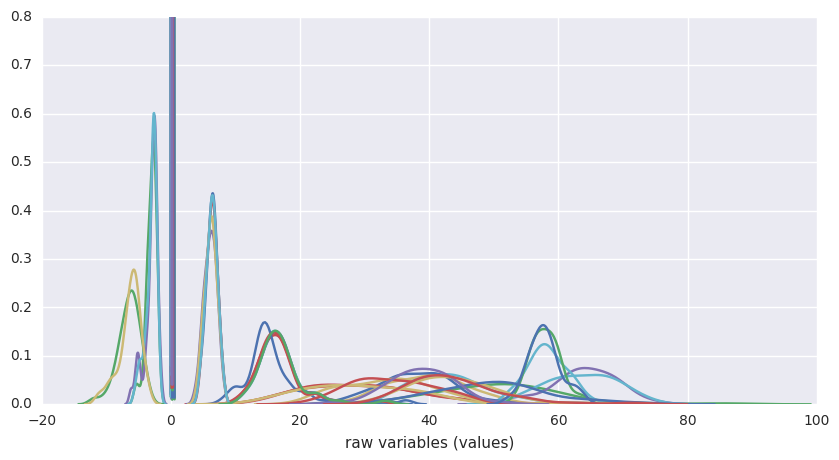

In [188]:
fig, ax = plt.subplots(figsize=(10,5))
print([c for c in d][:10])
for c in d:
    sns.distplot(d[c], hist=False)
ax.set_ylim(0,0.8)
ax.set_xlabel('raw variables (values)');

For percentage values:
['RF_MaxContactAt_(%)_Mean', 'RH_DutyCycle_(%)_Mean', 'RH_BodySpeedVariation_(%)_Mean', 'RF_BodySpeedVariation_(%)_Mean', 'LF_DutyCycle_(%)_Mean', 'LF_MaxContactAt_(%)_Mean', 'LF_BodySpeedVariation_(%)_Mean', 'RH_MaxContactAt_(%)_Mean', 'LH_DutyCycle_(%)_Mean', 'LH_BodySpeedVariation_(%)_Mean', 'FP_DutyCycle_(%)_Mean', 'LH_MaxContactAt_(%)_Mean', 'FP_MaxContactAt_(%)_Mean', 'RF_DutyCycle_(%)_Mean']


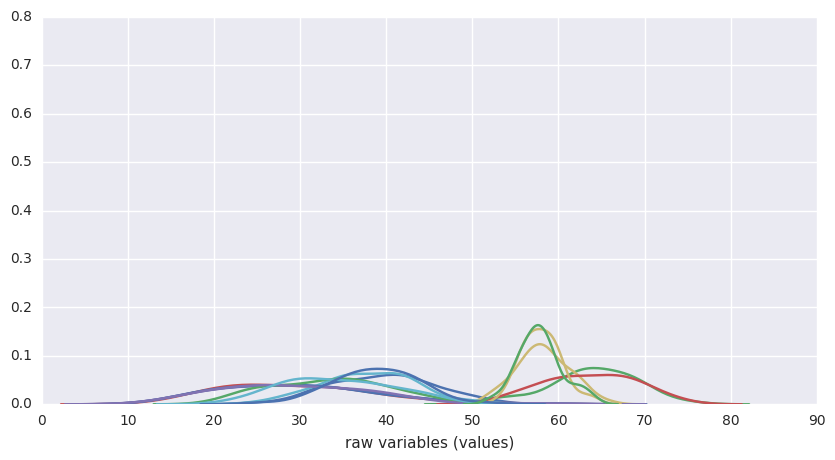

In [189]:
fig, ax = plt.subplots(figsize=(10,5))
d_n = select_columns_matching(d, '%')
print('For percentage values:')
print([c for c in d_n])
for c in d_n:
    sns.distplot(d_n[c], hist=False)
ax.set_ylim(0,0.8)
ax.set_xlabel('raw variables (values)');

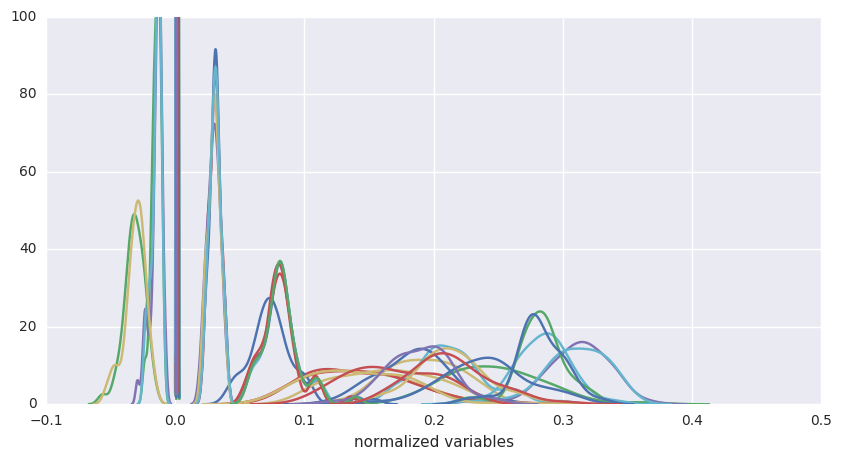

In [190]:
fig, ax = plt.subplots(figsize=(10,5))
d_n = normalize(d)
for i in range(d_n.shape[1]):
    sns.distplot(d_n[:,i], hist=False)
ax.set_ylim(0,100)
ax.set_xlabel('normalized variables');

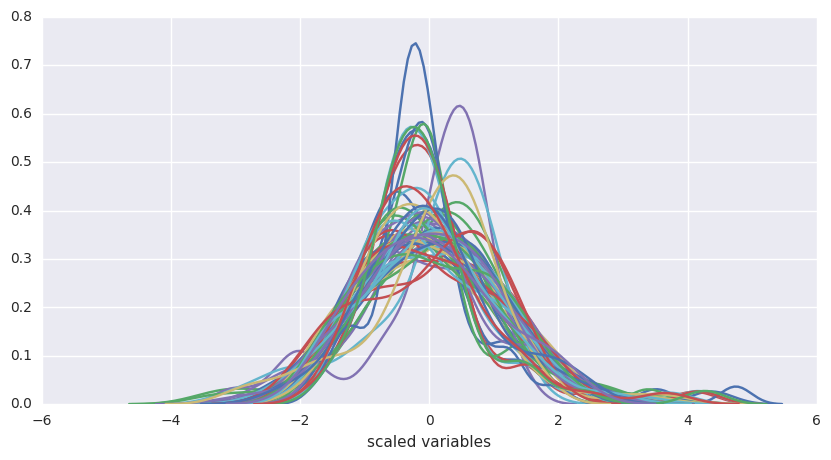

In [191]:
fig, ax = plt.subplots(figsize=(10,5))
d_n = scale(d) #, with_mean=False, with_std=False)
for i in range(d_n.shape[1]):
    sns.distplot(d_n[:,i], hist=False)

#ax.set_ylim(0,0.8)
ax.set_xlabel('scaled variables');

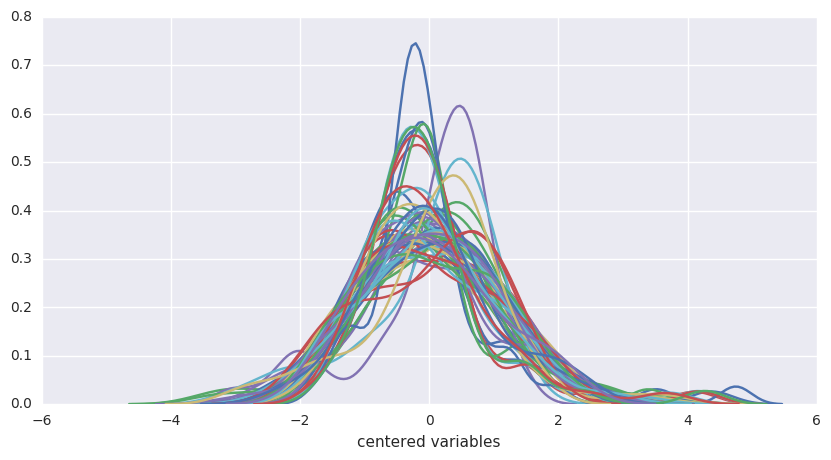

In [192]:
fig, ax = plt.subplots(figsize=(10,5))
d_n = scale(minmax_scale(d), with_std=True)
for i in range(d_n.shape[1]):
    sns.distplot(d_n[:,i], hist=False)

#ax.set_ylim(0,0.8)
ax.set_xlabel('centered variables');

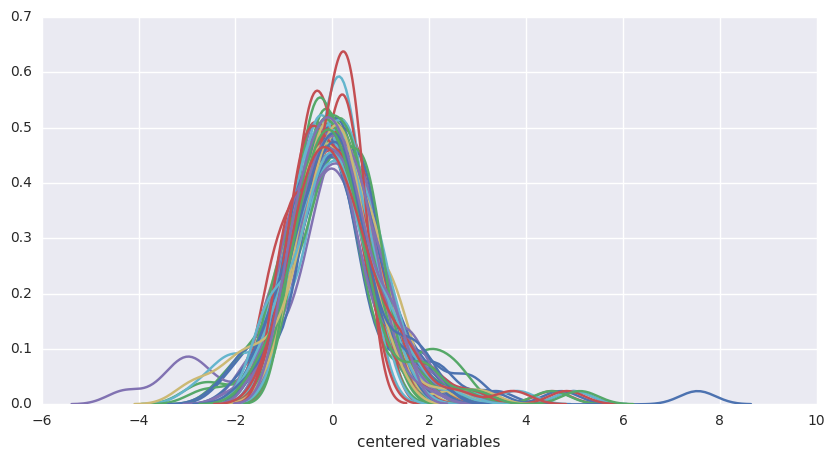

In [193]:
fig, ax = plt.subplots(figsize=(10,5))
d_n = robust_scale(d, with_scaling=True)
for i in range(d_n.shape[1]):
    sns.distplot(d_n[:,i], hist=False)

#ax.set_ylim(0,0.8)
ax.set_xlabel('centered variables');

In [197]:
print('Take a look at metadata')
md.sample(10)

Take a look at metadata


Group Animal
Group Animal             
AT    1.2       AT    1.2
YC    5.3       YC    5.3
AT    1.4       AT    1.4
YC    5.1       YC    5.1
      1.2       YC    1.2
      4.2       YC    4.2
AT    5.1       AT    5.1
YC    3.2       YC    3.2
AC    2.3       AC    2.3
AT    5.2       AT    5.2

In [198]:
print('How many observations are in each group?')
pd.DataFrame(md.Group.value_counts())

How many observations are in each group?


,Group
AT,20
YC,15
AC,10


# Top important features

### highest variance selection

In [199]:
selected_v, variances = sel_var(
    pd.DataFrame(maxabs_scale(d), columns = d.columns, index = d.index),
    0.001)

In [201]:
print("Features with highest variance")
selected_v = pd.DataFrame(variances.sort_values(ascending=False)[:20], columns = ['variance (maxabs scaling)'])
sel_v = selected_v.index.tolist()
selected_v

Features with highest variance


,variance (maxabs scaling)
RH_InitialDualStance_(s)_Mean,0.043066
RF_TerminalDualStance_(s)_Mean,0.042254
LF_InitialDualStance_(s)_Mean,0.039359
RH_TerminalDualStance_(s)_Mean,0.034026
LF_TerminalDualStance_(s)_Mean,0.033587
LH_TerminalDualStance_(s)_Mean,0.033157
LH_InitialDualStance_(s)_Mean,0.032987
RF_InitialDualStance_(s)_Mean,0.031408
FP_InitialDualStance_(s)_Mean,0.030197
LF_StandIndex_Mean,0.027984


### f classification selection (anova for all variables)

In [231]:
selected_a, support_a = sel_anova(dp, md[response_column], mode = 'classif')

In [232]:
selected_a = selected_a.ix[selected_a.pval < 0.05, :].reset_index().drop('index', axis=1)
sel_a = selected_a.param.tolist()
selected_a

,param,pval
0,LH_StrideLength_(cm)_Mean,1.694232e-08
1,FP_StrideLength_(cm)_Mean,4.252189e-08
2,LF_StrideLength_(cm)_Mean,5.135803e-08
3,RF_StrideLength_(cm)_Mean,6.048009e-08
4,RH_StrideLength_(cm)_Mean,6.621908e-08
5,RH_SingleStance_(s)_Mean,3.135726e-04
6,LH_SingleStance_(s)_Mean,5.463307e-04
7,LH_Swing_(s)_Mean,7.445412e-04
8,FP_SingleStance_(s)_Mean,1.429108e-03
9,RF_SingleStance_(s)_Mean,1.790273e-03


### mutual information classification selection

In [204]:
selected_m, pvals_m = sel_mi(dp, md[response_column], k=20)
sel_m = selected_m.columns.tolist()

In [205]:
print("Features selected by mutual_info_regression")
pd.DataFrame(selected_m.columns)

Features selected by mutual_info_regression


,0
0,RF_BodySpeed_(cm/s)_Mean
1,RF_StandIndex_Mean
2,RH_BodySpeed_(cm/s)_Mean
3,LF_BodySpeed_(cm/s)_Mean
4,LH_SingleStance_(s)_Mean
5,LH_Swing_(s)_Mean
6,LF_StandIndex_Mean
7,FP_StandIndex_Mean
8,LF_StrideLength_(cm)_Mean
9,LH_StandIndex_Mean


### Comparison of feature reduction methods

In [206]:
print("Number of selected features that overlap between methods (out of 20):")
print(' - var-f_reg:', str(sum([i in sel_a
                              for i in sel_v])),
                             "features.")
print(' - var-mi_reg:', str(sum([i in sel_m
                              for i in sel_v])),
                             "features.")
print(' - f_reg-mi_reg:', str(sum([i in sel_a
                              for i in sel_m])),
                             "features. \n")

Number of selected features that overlap between methods (out of 20):
 - var-f_reg: 5 features.
 - var-mi_reg: 4 features.
 - f_reg-mi_reg: 16 features. 



Accuracy for classifier param grid for response variable Group


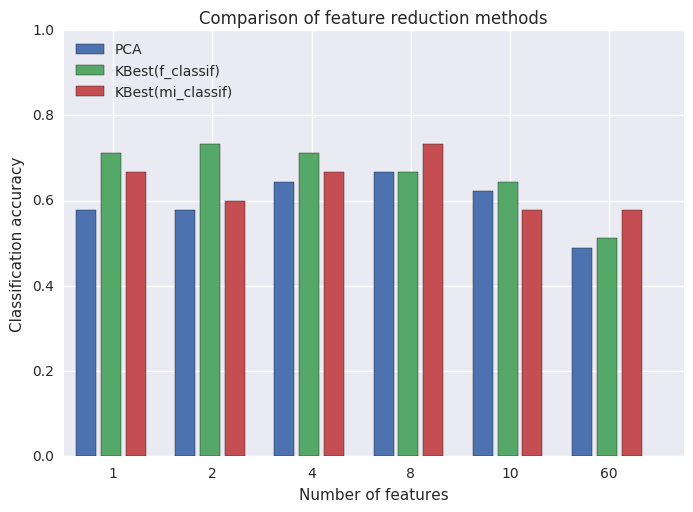

In [207]:
# regression problems:
#compare_dim_red_methods(normalize_pd(d, 0), round(md[response_column], 0), mode='regression')

# classification:
print('Accuracy for classifier param grid for response variable', response_column)
#compare_dim_red_methods(normalize_pd(d, 0, how='scale'), md[response_column], mode='classif')
compare_dim_red_methods(d, md[response_column], mode='classif')

# PCA

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


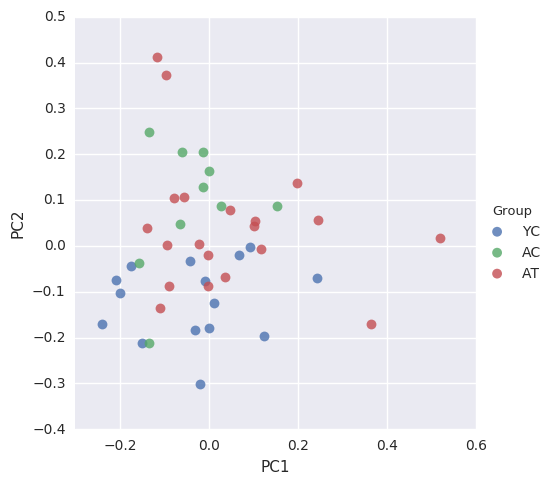

In [208]:
comps, exvar, pca = get_pc(dp)#, whiten=True)
print(pca)
#print(comps.head())
plot_comps = get_plot_comps(comps, md)
p2 = sns.lmplot(x='PC1', y='PC2', hue='Group', data=plot_comps, ci=None, fit_reg=False,
               scatter_kws={"s":50})

In [209]:
comps.shape

(45, 45)

In [210]:
#comps, exvar, pca = get_pc(dp, whiten=True)
#print(pca)
#plot_comps = get_plot_comps(comps, md)
#p2 = sns.lmplot(x='PC1', y='PC2', hue='Group', data=plot_comps, ci=None, fit_reg=False,
#               scatter_kws={"s":50})

In [211]:
print('Variance explained')
pd.DataFrame(exvar).T

Variance explained


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45
0,0.396307,0.205094,0.093443,0.071378,0.046853,0.035171,0.028655,0.024009,0.019564,0.011621,...,0.000086,0.000064,0.000057,0.000036,0.000013,0.000008,0.000005,0.000003,0.000001,6.545289e-32


In [212]:
print("12 PCs explain", round(sum(exvar[:12]), 2), "variance")

12 PCs explain 0.95 variance


The first two components seem to actually cluster both aged groups together, with some difference between the 'aged' cluster and 'young' cluster. There are some outliers from the Group 'aged treated'...

In [213]:
#p2 = sns.lmplot(x='PC1', y='PC2', hue='Trial', data=plot_comps.sort_values('Trial').iloc[:10,:],
#                ci=None, fit_reg=False, scatter_kws={"s":50})#, y_jitter=0.01, x_jitter=0.01)

In [214]:
# clusterplots for samples 1) PC3, PCall, all_var

In [215]:
palette=sns.color_palette('colorblind', len(md.Group.drop_duplicates()))
if not 'Colour' in md.columns:
    md.insert(1, 'Colour', md.Group)
    for i,g in enumerate(md.Colour.drop_duplicates()):
        md.Colour[md.Colour == g] = [palette[i] for c in range(sum(md.Colour == g))]

Distances between mice based on 3 variables or PCs. Dendrograms illustrate clustering of mice.


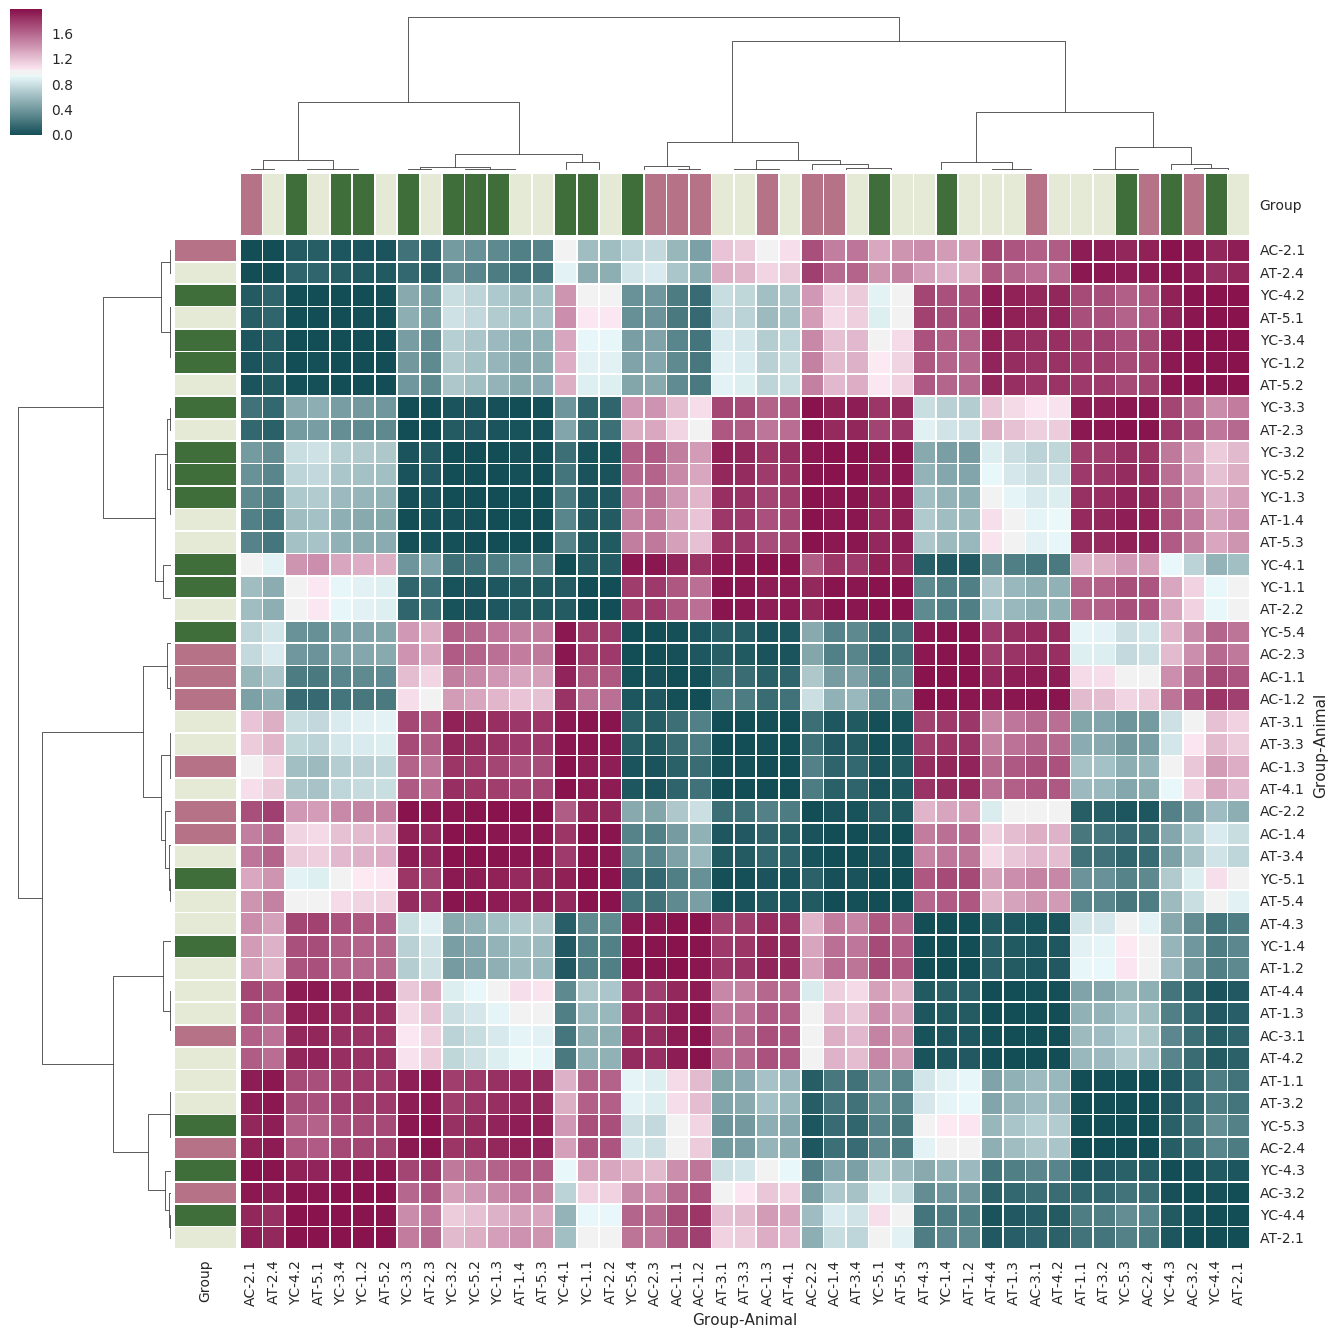

In [216]:
use_n = 3
print('Distances between mice based on', use_n, 'variables or PCs. Dendrograms illustrate clustering of mice.')
D = pd.DataFrame(pairwise_distances(comps.ix[:, :use_n],metric='correlation'),
                columns = comps.index, index = comps.index)
#sns.clustermap(x);
p3 = distance_matrix_plots(D, metric='correlation', method='average',
                           use_index_level="Group", figsize=(16,16), );

# Differences between groups

### Is there any difference between all groups? Cluster separation - ?

In [218]:
# Calculate distnace matrix on
# a) all data
D0 = pairwise_distances_pd(dp).applymap(lambda x: round(x,4))
# a) PCA var cutoff 95%
D1 = pairwise_distances_pd(comps.ix[:, :12]).applymap(lambda x: round(x,4))
# b) PCA 3 comps
D2 = pairwise_distances_pd(comps.ix[:, :3]).applymap(lambda x: round(x,4))

In [219]:
print(mantel(D0, D1))
print(mantel(D0, D2))
print(mantel(D1, D2))

(0.63889623339681234, 0.001, 45)
(0.8260039038433612, 0.001, 45)
(0.50064894081547873, 0.001, 45)


In [220]:
# silhouette analysis
# permutation of labels as a baseline score

In [221]:
print(silhouette_score(D0, metric='precomputed', labels=D0.index.get_level_values('Group')))
print(silhouette_score(D1, metric='precomputed', labels=D1.index.get_level_values('Group')))
print(silhouette_score(D2, metric='precomputed', labels=D2.index.get_level_values('Group')))

0.0165639805638
-0.00390703366235
0.0484377973608


**RESULT:** Suggest strong cluster overlap.

### Is there any difference between all groups? Compare with one variable: Gait Index - ANOVA

In [222]:
GI = comps.ix[:, :1].rename(columns={'PC1': 'GI'})
GI.to_csv('data/GI.tsv', sep="\t")
GI['GI_scaled'] = scale(GI['GI'])
GI.describe()

,GI,GI_scaled
count,4.500000e+01,4.500000e+01
mean,2.066248e-17,2.467162e-18
std,1.507557e-01,1.011300e+00
min,-2.411030e-01,-1.617368e+00
25%,-9.737769e-02,-6.532294e-01
50%,-1.321918e-02,-8.867695e-02
75%,6.815862e-02,4.572219e-01
max,5.197198e-01,3.486387e+00


In [223]:
[print(i.rstrip()) for i in anovaR('data/GI.tsv', 'GI~Group')];

anova <- aov(GI~Group, data=d)

            Df Sum Sq Mean Sq F value Pr(>F)
Group        2 0.0776 0.03882   1.768  0.183
Residuals   42 0.9224 0.02196


### Is there any difference between all groups? Comparison with multiple variables - MANOVA. 

Done on PCs - perhaps useful for global difference assessment, surely not for testing each variable.

http://www.sthda.com/english/wiki/manova-test-in-r-multivariate-analysis-of-variance

If the global multivariate test is significant, we conclude that the corresponding effect (treatment; here: group) is significant.

In [224]:
comps.to_csv('data/PCs.tsv', sep='\t')

In [237]:
support_a.to_csv('data/data_tmp.tsv', sep='\t')
[print(i.rstrip()) for i in manovaR(
        data_fp = 'data/data_tmp.tsv',
        #data_fp = 'data/PCs.tsv',
        #formula = 'cbind(PC1, PC2, PC3)~Group'
        formula = 'as.matrix(data[,3:40])~Group',
        #groups = ['YC', 'AC']
    )['summary']
];

ma <- manova(as.matrix(data[,3:40])~Group, data=data)

          Df Pillai approx F num Df den Df Pr(>F)
Group      2 1.7946   1.3793     76     12 0.2773
Residuals 42


**RESULTS**: There seems to be NOT a significant global difference between groups, although there is some. 

However, we are not interested in all of the variables, since inevitably some of them are not going to differ. Which actually do differ?
To answer this question, we can use one-way ANOVA (or univariate ANOVA) to examine separately each dependent variable.

In [241]:
#[print(i.rstrip()) for i in manovaR(
#        data_fp = 'data/data_ss31_p.tsv',
#        #data_fp = 'data/PCs.tsv',
#        #formula = 'cbind(PC1, PC2, PC3)~Group'
## three first cols are metadata; cannot fit more than 42 with 43 data points
#        formula = 'as.matrix(data[,3:20])~Group',
#        #groups = ['YC', 'AC']
#    )['summary.aov']
#];

selected_a

,param,pval
0,LH_StrideLength_(cm)_Mean,1.694232e-08
1,FP_StrideLength_(cm)_Mean,4.252189e-08
2,LF_StrideLength_(cm)_Mean,5.135803e-08
3,RF_StrideLength_(cm)_Mean,6.048009e-08
4,RH_StrideLength_(cm)_Mean,6.621908e-08
5,RH_SingleStance_(s)_Mean,3.135726e-04
6,LH_SingleStance_(s)_Mean,5.463307e-04
7,LH_Swing_(s)_Mean,7.445412e-04
8,FP_SingleStance_(s)_Mean,1.429108e-03
9,RF_SingleStance_(s)_Mean,1.790273e-03


### Is there a difference between any two groups? Comparison with multiple variables - MANOVA. 

In [248]:
print("Groups:", set(comps.index.get_level_values('Group')))

Groups: {'AT', 'YC', 'AC'}


We are going to use the first three principal components for all of the below analyses.

In [249]:
[print(i.rstrip()) for i in manova_contrastsR()['summary']];
#print('\n------\n Which variables contribute?\n')
#[print(i.rstrip()) for i in manova_contrastsR(groups = ['YC', 'AT'])['summary.aov']];

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=pcs)

          Df  Pillai approx F num Df den Df    Pr(>F)
Group      2 0.54235   5.0849      6     82 0.0001759 ***
Residuals 42
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [257]:
print('Between AC and AT?\n\n'+"="*60+"\n")
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'AT'])['summary']];
print('\n------\n Which variables contribute?\n')
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'AT'])['summary.aov']];

Between AC and AT?


ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

          Df  Pillai approx F num Df den Df Pr(>F)
Group      1 0.10733    1.042      3     26 0.3905
Residuals 28

------
 Which variables contribute?

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

 Response PC1 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.04901 0.049008  2.0922 0.1592
Residuals   28 0.65587 0.023424

 Response PC2 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.01633 0.016333  0.8105 0.3757
Residuals   28 0.56426 0.020152

 Response PC3 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.01139 0.011387  0.5086 0.4817
Residuals   28 0.62690 0.022389



In [258]:
print('Between AC and YC?\n\n'+"="*60+"\n")
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'YC'])['summary']];
print('\n------\n Which variables contribute?\n')
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'YC'])['summary.aov']];

Between AC and YC?


ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

          Df  Pillai approx F num Df den Df    Pr(>F)
Group      1 0.57933   9.6401      3     21 0.0003343 ***
Residuals 23
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------
 Which variables contribute?

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

 Response PC1 :
            Df  Sum Sq   Mean Sq F value Pr(>F)
Group        1 0.00008 0.0000799  0.0053 0.9424
Residuals   23 0.34406 0.0149589

 Response PC2 :
            Df  Sum Sq  Mean Sq F value    Pr(>F)
Group        1 0.26855 0.268552  23.067 7.611e-05 ***
Residuals   23 0.26777 0.011642
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PC3 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.03950 0.039498  1.6001 0.2185
Residuals   23 0.56773 0.024684



In [259]:
print('Between YC and AT?\n\n'+"="*60+"\n")
[print(i.rstrip()) for i in manovaR(groups = ['YC', 'AT'])['summary']];
print('\n------\n Which variables contribute?\n')
[print(i.rstrip()) for i in manovaR(groups = ['YC', 'AT'])['summary.aov']];

Between YC and AT?


ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

          Df  Pillai approx F num Df den Df    Pr(>F)
Group      1 0.51272   10.873      3     31 4.847e-05 ***
Residuals 33
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------
 Which variables contribute?

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

 Response PC1 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.05776 0.057761  2.2563 0.1426
Residuals   33 0.84479 0.025600

 Response PC2 :
            Df  Sum Sq  Mean Sq F value    Pr(>F)
Group        1 0.22513 0.225131   14.93 0.0004942 ***
Residuals   33 0.49760 0.015079
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PC3 :
            Df  Sum Sq  Mean Sq F value   Pr(>F)
Group        1 0.12855 0.128550  7.7648 0.008764 **
Residuals   33 0.54633 0.016555
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



**RESULTS**: This test suggests that:
1. 'Aged Ctrl' and 'young ctrl', as well as 'ss31 aged injected' and 'young ctrl' seem to be significantly different.
2. There seems to be no significant difference between 'Aged Ctrl' and 'ss31 aged injected'.

### * is neurovascular decoupling different between groups?